In [1]:
#!/usr/bin/python
# by DBR 8/2017 #

%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import scipy.stats as st
import time

import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1))


In [202]:
#gillespie HIV model inspired by Keeling/Rohani+Soumpasis
def single_strain_dynamics_hybrid(X0,t_list,thL,enzyme_prob,dose_time):
            
    t=0; ind1=0; ind2=0; dt=t_list[1]; #initialize step, vectors for times, dt for deterministic part
    
    x=X0; x_track=np.zeros(len(t_list)); x_track[0]=X0 #initialize state variables
    
    T=np.array([1,-1]) #birth death transition matrix
    
    aL=0.015 #birth rate, doesn't matter really
    dL=aL-thL

    dose_index=0 #index for CRISPR doses    
    while t < t_list[-1] and x>0:

        ind2=np.argmin(t+dt>t_list) #calculate where in the observations the time falls index

        #add to xtrack if we've gone by one of the t_list moments, or more than 1 in case gillespie
        if ind2>ind1:
            x_track[ind1+1:ind2+1]=x #fill up x_track
            ind1=ind2 #update the first time index

        if t>dose_time[dose_index]:
            x=x*enzyme_prob
            dose_index+=1

        #tauleaping method
        if x>100:
            #dx=thL*x*dt
            dx=np.random.poisson(aL*x*dt)-np.random.poisson(np.abs(dL)*x*dt)*np.sign(dL) #account for positive thL
            x=x+np.round(dx)  
            
        #gillespie method
        else:
            r=np.array([aL*x,dL*x]) #compute the rates

            U1=np.random.uniform() #first uniform random number

            dt=-np.log(U1)/(np.sum(r)); #draw a timestep from an exponential distribution based on total rates

            U2=np.random.uniform() #second random uniform number

            wT=np.argmax(np.cumsum(r)/np.sum(r)>=U2) #calculate which transition occured

            x=x+T[wT] #update state variable

            if x<1:
                x=0
        
        t=t+dt
                    
    return x_track


/Users/danielreeves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


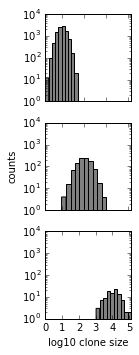

In [196]:
#let's try 3 different distributions

#lognormal around 1e2,1e3,1e4
L0=1e6
cp=[]
lam_list=[]
fig,axarr=plt.subplots(3,1,dpi=600,figsize=(2,5),sharex=True,sharey=True)
for i in range(3):
    log_avgc=i+2
    cp.append(10**np.random.normal(log_avgc,log_avgc/10,[L0/10**(log_avgc)]))

    axarr[i].hist(np.log10(cp[i]),bins=10,color='gray')
    plt.yscale('log')
    plt.xticks(range(6))
    
axarr[1].set_ylabel('counts')
axarr[2].set_xlabel('log10 clone size')
    
plt.tight_layout()
plt.savefig('distributions.pdf')
plt.savefig('distributions.svg')

In [170]:
cz=['darkred', 'seagreen', 'slateblue']

#now simulate those distributions
tF=7*25
tPts=1e4
t=np.linspace(0,tF,tPts)

num_ds=100 #number of sample points to actually have
ds_factor=int(tPts/100) #calculate the array slice factor

dose_time=np.linspace(7,tF,tF/7) #weekly doses

aL=0.015 #birth rate, doesn't matter really

efficiency=[0.8,0.9,0.99]
coverage=[80,90,99]

L_list=[] #all the total reservoirs
sim_list=[] #all the downsampled simulations
sim_num=1 #to keep track of sims
tz1=time.time() #to keep track of computation time of the simulations
#loop reservoir makeups
for i in np.arange(len(cp)):
    clones=cp[i]
    num_strains=len(clones)
    
    half_life=np.random.normal(3.6,1.5,[num_strains])#choose a decay rate bsaed on Crooks with an estimated mean half-life of 3.6 years (95% confidence interval, 2.3–8.1 years),
    thL_list=-np.log(2)/half_life/365 #calculate decay rate in days
    
    #loop CRISPR potency
    for j_e in range(len(efficiency)):    
        enzyme_efficieny=efficiency[j_e]
        coverage_pct=coverage[j_e]
        
        enzyme_prob=np.ones(num_strains) #makes no change x (see above)
        enzyme_prob[0:int(num_strains*coverage_pct/100)]=1-enzyme_efficieny

        multi_x=[]
        #simulate for each strain
        for s in range(num_strains):
            csize=clones[s]

            thL=thL_list[s]
            zp=enzyme_prob[s]

            x_track=single_strain_dynamics_hybrid(csize,t,thL,zp,dose_time) 
            x_ds=x_track[::ds_factor]
            multi_x.append(x_ds)

        sim_list.append(multi_x)
        L=np.sum(multi_x,0) #the total resservoir
                
        L_list.append(L) #add to total L list
        
        tz2=time.time()
        print(sim_num,'/',str(len(efficiency)*len(cp)),' took',(tz2-tz1),'s')
        tz1=tz2
        sim_num+=1
        


1 / 9  took 136.0911681652069 s
2 / 9  took 79.65103387832642 s
3 / 9  took 28.691335916519165 s
4 / 9  took 26.906334161758423 s
5 / 9  took 15.72282886505127 s
6 / 9  took 5.29519510269165 s
7 / 9  took 3.428457021713257 s
8 / 9  took 1.9193530082702637 s
9 / 9  took 0.7149178981781006 s


2.234480142593384 s
2.496670961380005 s
3.733428955078125 s
2.931489944458008 s
3.539577007293701 s
3.582202196121216 s
0.7708179950714111 s
1.0816059112548828 s
0.7894799709320068 s


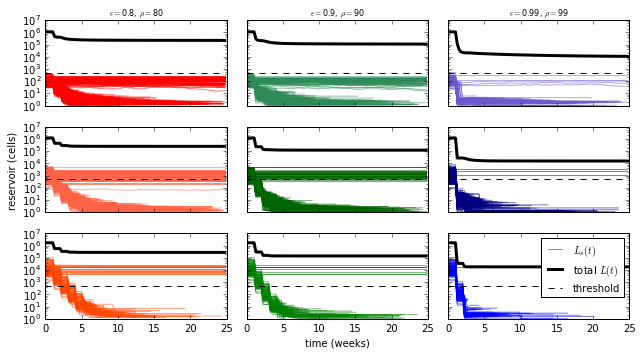

In [181]:
#plot the strainwise examples
cz2=['red','seagreen','slateblue',
     'tomato','darkgreen','navy',
     'orangered','green','blue']

leg_list=[r'$\lambda$']

t_ds=t[::ds_factor]/7

maxsimz=500 #maximum number of lines to draw

fig,axarr=plt.subplots(3,3,figsize=(9,5),dpi=600,sharex=True,sharey=True)
tz1=time.time() #to keep track of computation time of the simulations
for i in range(len(sim_list)):
    ax=axarr[int(i/3)][i%3]

    nsimz=len(sim_list[i]) #need to check if bigger/smaller than max number
    if nsimz>maxsimz: # don't plot everything it takes too long
        for j in range(maxsimz):
            kl1=ax.semilogy(t_ds,sim_list[i][np.random.randint(0,nsimz)],color=cz2[i],alpha=0.5)
    else:
        for j in range(nsimz):
            kl1=ax.semilogy(t_ds,sim_list[i][j],color=cz2[i],alpha=0.5)
    
    kl2=ax.semilogy(t_ds,L_list[i],color='k',lw=3)

    thr=ax.plot(t_ds,np.ones(len(t_ds))*500,ls='--',lw=1,color='k')
    tz2=time.time()
    print((tz2-tz1),'s')
    tz1=tz2
    
ax.legend(kl1+kl2+thr,[r'$L_s(t)$',r'total $L(t)$','threshold'],fontsize=10)
for i in range(3):
    axarr[0][i].set_title('$\epsilon=$'+str(efficiency[i])+r', $\rho=$'+str(coverage[i]),fontsize=8)
    
axarr[1][0].set_ylabel('reservoir (cells)')
axarr[2][1].set_xlabel('time (weeks)')
axarr[0][0].set_ylim([1,1e7])
plt.tight_layout()
plt.savefig('examples_strainwise.pdf')
plt.savefig('examples_strainwise.svg')

    

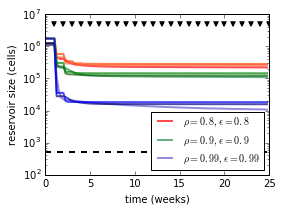

In [197]:
plt.figure(figsize=(4,3),dpi=600)

for i in range(9):
    plt.semilogy(t_ds,L_list[i],color=cz2[i],lw=2,alpha=0.7)

plt.legend([r'$\rho=0.8, \epsilon=0.8$',
            r'$\rho=0.9, \epsilon=0.9$',
            r'$\rho=0.99, \epsilon=0.99$'],fontsize=10,loc=4)
            
plt.ylabel('reservoir size (cells)')
plt.xlabel('time (weeks)')
plt.scatter(dose_time/7,np.ones(len(dose_time))*5e6,marker='v',color='k')
plt.axhline(500,lw=2,color='k',ls='--')
plt.xlim([0,25])
plt.tight_layout()
plt.savefig('examples_total.pdf')
plt.savefig('examples_total.svg')


In [203]:
#now do simulations for many drug efficiencies to look at 1 year

tF=7*52
tPts=1e4
t=np.linspace(0,tF,tPts)

num_ds=100 #number of sample points to actually have
ds_factor=int(tPts/100) #calculate the array slice factor

dose_time=np.linspace(7,tF,tF/7) #weekly doses

efficiency=np.linspace(0.5,0.99,10)
coverage=np.linspace(50,99,10)

clones=cp[1]; num_strains=len(clones) #choose the middle reservoir makeup

half_life=np.random.normal(3.6,1.5,[num_strains])#choose a decay rate bsaed on Crooks with an estimated mean half-life of 3.6 years (95% confidence interval, 2.3–8.1 years),
thL_list=-np.log(2)/half_life/365 #calculate decay rate in days

L3=np.zeros([10,10,num_ds]);  #list for half year and full year

#loop CRISPR potency
sim_num=1 #to keep track of sims
tz1=time.time() #to keep track of computation time of the simulations
for j_e in range(len(efficiency)):    
    for j_c in range(len(coverage)):

        enzyme_efficieny=efficiency[j_e]
        coverage_pct=coverage[j_c]

        enzyme_prob=np.ones(num_strains) #makes no change x (see above)
        enzyme_prob[0:int(num_strains*coverage_pct/100)]=1-enzyme_efficieny

        multi_x=[]
        #simulate for each strain
        for s in range(num_strains):
            csize=clones[s]

            thL=thL_list[s]
            zp=enzyme_prob[s]

            x_track=single_strain_dynamics_hybrid(csize,t,thL,zp,dose_time) 
            x_ds=x_track[::ds_factor]
            multi_x.append(x_ds)

        L3[j_e,j_c,:]=np.sum(multi_x,0) #the total resservoir in 3D form
 
        tz2=time.time()
        print(sim_num,'/',str(len(efficiency)*len(coverage)),' took',(tz2-tz1),'s')
        tz1=tz2
        sim_num+=1



1 / 100  took 73.40939688682556 s
2 / 100  took 65.9153311252594 s
3 / 100  took 61.354068994522095 s
4 / 100  took 53.115779876708984 s
5 / 100  took 47.41389203071594 s
6 / 100  took 39.35847496986389 s
7 / 100  took 32.30501413345337 s
8 / 100  took 25.173199892044067 s
9 / 100  took 18.36979913711548 s
10 / 100  took 12.0743088722229 s
11 / 100  took 72.34555292129517 s
12 / 100  took 66.32582807540894 s
13 / 100  took 60.230695962905884 s
14 / 100  took 53.06526708602905 s
15 / 100  took 45.95209288597107 s
16 / 100  took 39.071638107299805 s
17 / 100  took 32.49069809913635 s
18 / 100  took 25.24696183204651 s
19 / 100  took 18.265961170196533 s
20 / 100  took 11.18222188949585 s
21 / 100  took 74.04642796516418 s
22 / 100  took 67.90709710121155 s
23 / 100  took 59.19213795661926 s
24 / 100  took 52.41556692123413 s
25 / 100  took 45.07380414009094 s
26 / 100  took 38.00257897377014 s
27 / 100  took 30.99900197982788 s
28 / 100  took 23.91800093650818 s
29 / 100  took 17.0754599

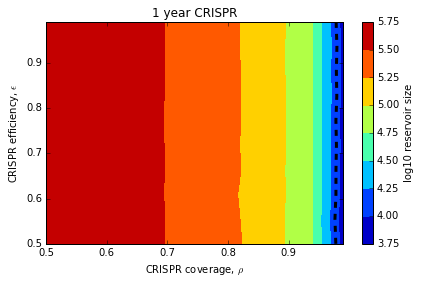

In [282]:
#single heat map 1 year of CRISPR weekly doses

CS=plt.contour(coverage/100,efficiency,np.log10(L3[:,:,-1]),levels = [4.1,], colors=('k',),linewidths=(3,),linestyles=('--',))
plt.contourf(coverage/100,efficiency,np.log10(L3[:,:,-1]))#,vmin=1,vmax=5)#,levels=np.linspace(0,3,11))
plt.xlabel(r'CRISPR coverage, $\rho$')
#plt.ylim([0.2,0.9])
plt.ylabel(r'CRISPR efficiency, $\epsilon$')
cbar=plt.colorbar()
cbar.set_label('log10 reservoir size')
plt.title('1 year CRISPR')

plt.tight_layout()
plt.savefig('treatment_comparison_heatmap.pdf')
plt.savefig('treatment_comparison_heatmap.svg')


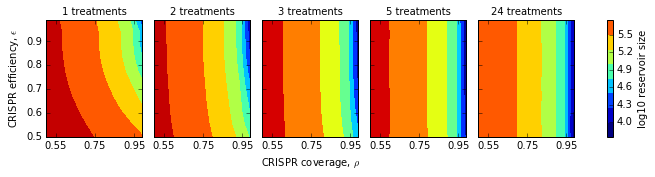

In [295]:
#several heat maps for different times

fig,axarr=plt.subplots(1,5,figsize=(10,2.5),dpi=600,sharex=True,sharey=True)
inz=[4,8,12,20,99]
for i in range(5):
    #axarr[i].contour(coverage/100,efficiency,np.log10(L3[:,:,inz[i]]),levels = [4.1,], colors=('k',),linewidths=(3,),linestyles=('--',))
    cmap=axarr[i].contourf(coverage/100,efficiency,np.log10(L3[:,:,inz[i]]),vmin=4,vmax=6)#,levels=np.linspace(4,6,11))
    axarr[i].set_title(str(int(t_ds[inz[i]]))+' treatments', fontsize=10)
    axarr[i].set_xticks([0.55,0.75,0.95])

    
axarr[0].set_ylabel(r'CRISPR efficiency, $\epsilon$')
axarr[2].set_xlabel('CRISPR coverage,' + r' $\rho$')

plt.tight_layout()

cbar=plt.colorbar(cmap,ax=axarr.ravel().tolist())
cbar.set_label('log10 reservoir size')
cbar.set_ticks(np.linspace(4,7,11))
    
plt.savefig('efficiency_coverage_heatmap.pdf')
plt.savefig('efficiency_coverage_heatmap.svg')


In [288]:
#do simulations with perfect coverage!

tF=7*52
tPts=1e4
t=np.linspace(0,tF,tPts)

num_ds=100 #number of sample points to actually have
ds_factor=int(tPts/100) #calculate the array slice factor

dose_time=np.linspace(7,tF,tF/7) #weekly doses

efficiency=np.linspace(0.5,0.99,10)

clones=cp[1]; num_strains=len(clones) #choose the middle reservoir makeup

half_life=np.random.normal(3.6,1.5,[num_strains])#choose a decay rate bsaed on Crooks with an estimated mean half-life of 3.6 years (95% confidence interval, 2.3–8.1 years),
thL_list=-np.log(2)/half_life/365 #calculate decay rate in days

Lperfect=np.zeros([10,num_ds]);  #list for half year and full year

#loop CRISPR potency
sim_num=1 #to keep track of sims
tz1=time.time() #to keep track of computation time of the simulations
for j_e in range(len(efficiency)):    

    enzyme_efficieny=efficiency[j_e]
    coverage_pct=100

    enzyme_prob=np.ones(num_strains) #makes no change x (see above)
    enzyme_prob[0:int(num_strains*coverage_pct/100)]=1-enzyme_efficieny

    multi_x=[]
    #simulate for each strain
    for s in range(num_strains):
        csize=clones[s]

        thL=thL_list[s]
        zp=enzyme_prob[s]

        x_track=single_strain_dynamics_hybrid(csize,t,thL,zp,dose_time) 
        x_ds=x_track[::ds_factor]
        multi_x.append(x_ds)

    Lperfect[j_e,:]=np.sum(multi_x,0) #the total resservoir in 3D form

    tz2=time.time()
    print(sim_num,'/',str(len(efficiency)*len(coverage)),' took',(tz2-tz1),'s')
    tz1=tz2
    sim_num+=1



1 / 100  took 10.59995698928833 s
2 / 100  took 9.199572086334229 s
3 / 100  took 8.156049966812134 s
4 / 100  took 7.218297004699707 s
5 / 100  took 6.384526014328003 s
6 / 100  took 5.72673487663269 s
7 / 100  took 5.033050060272217 s
8 / 100  took 4.432106018066406 s
9 / 100  took 3.6461539268493652 s
10 / 100  took 2.7578611373901367 s


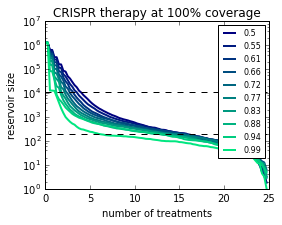

In [314]:
plt.figure(figsize=(4,3),dpi=600)
for i in range(len(efficiency)):
    plt.semilogy(t_ds,Lperfect[i,:],color=[0,0.1*i,0.5],lw=2)
plt.axhline(1.1e4,lw=1,ls='--',color='k')
plt.axhline(200,lw=1,ls='--',color='k')
plt.legend(np.round(efficiency,2),fontsize=8)
plt.xlabel('number of treatments')
plt.ylabel('reservoir size')
plt.title('CRISPR therapy at 100% coverage')

plt.savefig('100%coverage.pdf')
plt.savefig('100%coverage.svg')


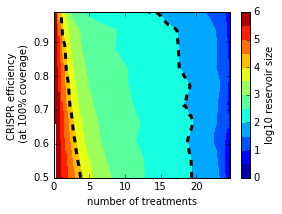

In [316]:
plt.figure(figsize=(4,3),dpi=600)

plt.contour(t_ds,efficiency,np.log10(Lperfect),levels = [2,4.1], colors=('k',),linewidths=(3,),linestyles=('--',))
plt.contourf(t_ds,efficiency,np.log10(Lperfect),levels=np.linspace(0,6,13))

plt.ylabel('CRISPR efficiency \n (at 100% coverage)')
plt.xlabel('number of treatments')
plt.tight_layout()

cbar=plt.colorbar()
cbar.set_label('log10 reservoir size')
#cbar.set_ticks(np.linspace(1,7,11))
    
plt.savefig('efficiency_time_heatmap.pdf')
plt.savefig('efficiency_time_heatmap.svg')
